In [1]:
import findspark
SPARK_HOME = %env SPARK_HOME
findspark.init(SPARK_HOME)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.titlesize': 0, 'figure.figsize' : (4,3)})

import os
from os import listdir
from functools import reduce
import sys

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType , BooleanType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName('yahoo').getOrCreate()
sc = spark.sparkContext

In [3]:
import mlflow
from mlflow import log_metric, log_param, log_artifact, pyfunc
from mlflow.pyfunc import PythonModel

"""
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./artifacts \
    --host 0.0.0.0
"""

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("yahoo")

### File imports and EDA

In [66]:
mainpath = "yahoo_data/A2BENCHMARK/"
np.random.seed(111)
all_files = [f.name for f in os.scandir(mainpath) if f.is_file()]
test_files = np.random.choice(all_files, 30, replace=False)
[os.rename(mainpath + t, mainpath + "train/" + t) for t in  (set(all_files)-set(test_files))]
[os.rename(mainpath + t, mainpath + "test/" + t) for t in test_files]
len(test_files)

30

In [4]:
#Load in one of the training sets for EDA
mainpath = "yahoo_data/A2BENCHMARK/"
df0 = spark.read.options(header='true', inferschema='true').csv(mainpath+"/train/synthetic_47.csv")
df0.printSchema()
df0.show(5,False)

root
 |-- timestamp: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- is_anomaly: integer (nullable = true)

+----------+----------------+----------+
|timestamp |value           |is_anomaly|
+----------+----------------+----------+
|1416726000|597.938711414164|0         |
|1416729600|-73.180074343761|0         |
|1416733200|783.990456058544|0         |
|1416736800|833.730107323925|0         |
|1416740400|505.84697394432 |0         |
+----------+----------------+----------+
only showing top 5 rows



### Feature Engineering

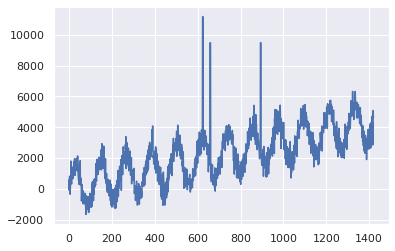

In [225]:
%matplotlib inline
npdf0 = df0.toPandas().value.to_numpy()
p = plt.plot(npdf0)

In [226]:
#FFT
sig_fft = sp.fftpack.fft(npdf0)
sig_psd = np.abs(sig_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(sig_psd), 1. / (24*7))

In [227]:
sns.reset_orig()

Text(0, 0.5, 'PSD')

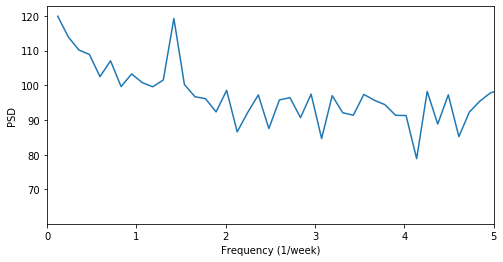

In [228]:
#Power spectral density plot
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[fftfreq > 0], 10 * np.log10(sig_psd[fftfreq > 0]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/week)')
ax.set_ylabel('PSD')

In [231]:
#Find fundamental/dominant frequencies
sig_fft_bis = np.where(np.abs(fftfreq) > 1.5, 0, sig_fft)
sig_slow = np.real(sp.fftpack.ifft(sig_fft_bis))

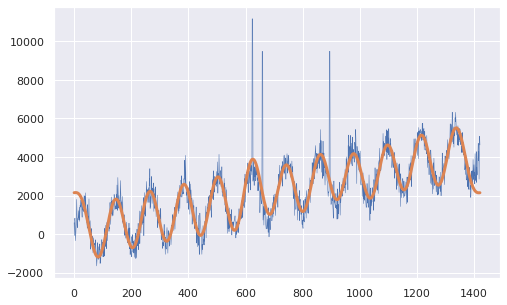

In [232]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(npdf0, lw=.5)
ax.plot(sig_slow, '-', lw=3)

In [233]:
from ipywidgets import interact

@interact
def plot(cutoff=(0.0, 5.0)):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sig_fft_bis = np.where(np.abs(fftfreq) > cutoff, 0, sig_fft)
    sig_slow = np.real(sp.fftpack.ifft(sig_fft_bis))
    plt.plot(npdf0, lw=.5)
    ax.plot(sig_slow, '-', lw=3)
    plt.show()

interactive(children=(FloatSlider(value=2.5, description='cutoff', max=5.0), Output()), _dom_classes=('widget-…

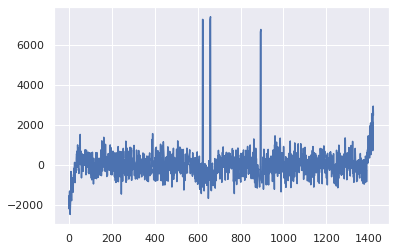

In [234]:
%matplotlib inline
sub = np.subtract(npdf0, sig_slow)
plt.plot(sub)

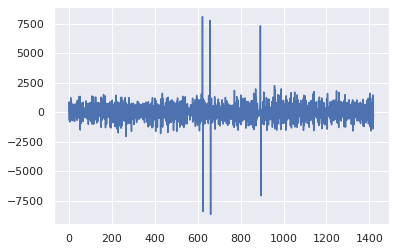

In [235]:
plt.plot(np.diff(sub))

In [236]:
len(df0.toPandas()[df0.toPandas().is_anomaly == 1])

9

### File processing and transforms

In [5]:
#Load in all train/test sets from CSV folders
train_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"train/{csv}") for csv in os.listdir(mainpath + "train/")]
test_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"test/{csv}") for csv in os.listdir(mainpath + "test/")]

In [6]:
"""
Function to remove fundamental/dominant frequencies via subtraction
"""
@F.pandas_udf('double')
def remove_season(col, cutoff=1.5):
    arr = col.to_numpy()
    sig_fft = sp.fftpack.fft(arr)
    sig_psd = np.abs(sig_fft) ** 2
    fftfreq = sp.fftpack.fftfreq(len(sig_psd), 1. / (24*7))
    sig_fft_bis = np.where(np.abs(fftfreq) > cutoff, 0, sig_fft)
    sig_slow = np.real(sp.fftpack.ifft(sig_fft_bis))
    
    sub = np.subtract(arr, sig_slow)  #Subtract season from original array
    return pd.Series(sub)

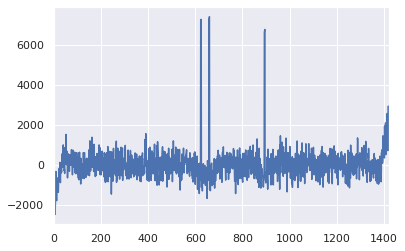

In [239]:
df0.withColumn("sub", remove_season(F.col("value"))).toPandas()['sub'].plot()

In [7]:
"""
Prepare DFs for inference
- add column of value with fundamental frequency removed
- add column of 1st diff and backfill NA values
- Find std, 1st and 3rd quantile of both value and diff'd value
"""
def prepare_df(df: DataFrame) -> DataFrame:
    
    outdf = df.withColumn("sub",  remove_season(F.col("value")))
    
    ts_window = Window.partitionBy().orderBy("timestamp")
    outdf = outdf.withColumn("value_lag1", F.lag(F.col("sub")).over(ts_window))
    outdf = (outdf.withColumn("value_diff1", F.when(F.isnull(outdf.value - outdf.value_lag1), 0)
                                              .otherwise(outdf.value - outdf.value_lag1)))
    
    #2nd difference
    #outdf = outdf.withColumn("value_diff1_lag1", F.lag(F.col("value_diff1")).over(ts_window))
    #outdf = (outdf.withColumn("value_diff2", F.when(F.isnull(outdf.value_diff1 - outdf.value_diff1_lag1), 0)
    #                                          .otherwise(outdf.value_diff1 - outdf.value_diff1_lag1)))
    
    #outdf = outdf.na.fill(0)
    # Use backfill instead of na
    bf_window = Window.orderBy('timestamp').rowsBetween(0, sys.maxsize)
    outdf = (outdf.withColumn('value_lag1', F.first(outdf['value_lag1'], ignorenulls=True).over(bf_window)))
                  #.withColumn('value_diff1_lag1', F.first(outdf['value_diff1_lag1'], ignorenulls=True).over(bf_window)))
                             
    quantiles = outdf.approxQuantile("sub", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("sub")).alias("std")))
                  .withColumn("q1", F.lit(quantiles[0]))
                  .withColumn("q3", F.lit(quantiles[1])))
                
    quantiles = outdf.approxQuantile("value_diff1", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff1")).alias("std2")))
              .withColumn("q1_2", F.lit(quantiles[0]))
              .withColumn("q3_2", F.lit(quantiles[1])))

    return outdf

In [250]:
prepare_df(df0).limit(3).toPandas()

,timestamp,value,is_anomaly,sub,value_lag1,value_diff1,std,q1,q3,std2,q1_2,q3_2
0,1416726000,597.938711,0,-1553.895157,-1553.895157,0.000000,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507
1,1416729600,-73.180074,0,-2226.736800,-1553.895157,1480.715083,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507
2,1416733200,783.990456,0,-1371.174868,-2226.736800,3010.727256,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507


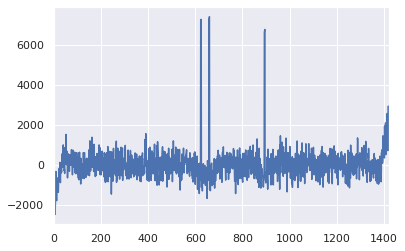

In [241]:
prepare_df(df0).toPandas()['sub'].plot()

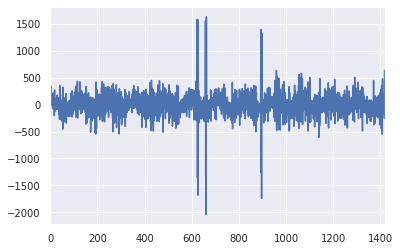

In [119]:
prepare_df(train_dfs[45]).toPandas().value_diff2.plot()

In [8]:
prepared_train_dfs = list(map(prepare_df, train_dfs))
prepared_test_dfs = list(map(prepare_df, test_dfs))
train_df = reduce(DataFrame.unionAll, prepared_train_dfs)
test_df = reduce(DataFrame.unionAll, prepared_test_dfs)

### Model Definition and udf wrapping

In [236]:
#Tukey's Fences outlier detection
def predict_from_quants(sub: float, q1: float, q3: float, value_diff1: float, q1_2: float, q3_2: float) -> float:
    threshold, threshold2 = (5, 10)
    Q1, Q1_2 = (float(q1), float(q1_2))
    Q3, Q3_2 = (float(q3), float(q3_2))
    IQR, IQR_2 = (Q3 - Q1, Q3_2 - Q1_2)
    if (float(sub) < (Q1 - IQR*threshold) or float(sub) > Q3 + IQR*threshold or
        float(value_diff1) < (Q1_2 - IQR_2*threshold2) or float(value_diff1) > Q3_2 + IQR_2*threshold2):
        return 1.0
    else:
        return 0.0
    
#Wrapper for MLflow saving/loading
prediction_fn_vectorized = np.vectorize(predict_from_quants)
class UDFWrapper(PythonModel):
    def __init__(self, estimator=None):
        return None
    def predict(self, context, X):
        return np.array(prediction_fn_vectorized(*X.to_numpy().T))

In [61]:
UDFWrapper().predict(spark, prepare_df(df0).select(in_cols).toPandas())

array([0., 0., 0., ..., 0., 1., 1.])

In [66]:
from typing import Callable
in_cols = ["sub", "q1", "q3", "value_diff1", "q1_2", "q3_2"]
def apply_prediction(df: DataFrame, prediction_function: Callable, columns):
    return df.withColumn("prediction", F.udf(prediction_function, DoubleType())(*columns))

# Load model from registry
def apply_prediction_saved(df: DataFrame, model_path: str = "models:/yahoo_model_FFT_nodiff_deseason/Production", columns = in_cols):
    prediction_udf = mlflow.pyfunc.spark_udf(spark, model_path)
    return df.withColumn('prediction', prediction_udf(*columns))

In [12]:
apply_prediction(prepare_df(df0), predict_from_quants, in_cols).limit(3).toPandas()

,timestamp,value,is_anomaly,sub,value_lag1,value_diff1,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,597.938711,0,-1553.895157,-1553.895157,0.000000,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0
1,1416729600,-73.180074,0,-2226.736800,-1553.895157,1480.715083,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0
2,1416733200,783.990456,0,-1371.174868,-2226.736800,3010.727256,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0


In [69]:
apply_prediction_saved(prepare_df(df0)).limit(3).toPandas()

,timestamp,value,is_anomaly,sub,value_lag1,value_diff1,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,597.938711,0,-1553.895157,-1553.895157,0.000000,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0
1,1416729600,-73.180074,0,-2226.736800,-1553.895157,1480.715083,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0
2,1416733200,783.990456,0,-1371.174868,-2226.736800,3010.727256,803.281539,-414.863666,275.025056,1752.713199,1031.157165,3174.77507,0.0


### Benchmarking, MLflow logging

In [237]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
prediction = apply_prediction(test_df, predict_from_quants, in_cols)
AuROC = evaluator.evaluate(prediction)
AuPR  = evaluator.setMetricName("areaUnderPR").evaluate(prediction)
print(AuROC,AuPR)
log_artifact("yahoo_FFT.ipynb", "jup_logs")
log_param("type", "quantile_FFT_deseason")
log_param("na_fill_type", "backfill")
log_param("threshold1", str(5))
log_param("threshold2", str(10))
log_metric("AreaUnderROC", AuROC)
log_metric("AreaUnderPR", AuPR)

"""
Currently, loading the model after saving it ends the run. In order to associate the current model with its params, I'm logging it again.
The consequences of this are that useful model versions iterate by 2, and every other experiment run is empty
"""
mlflow.pyfunc.log_model(
            python_model=UDFWrapper(),
            registered_model_name="yahoo_model_FFT_nodiff_deseason",
            artifact_path="yahoo_models"
        )
mlflow.end_run()

0.9606336187408044 0.2532724171894021


Registered model 'yahoo_model_FFT_nodiff_deseason' already exists. Creating a new version of this model...
Created version '21' of model 'yahoo_model_FFT_nodiff_deseason'.


In [238]:
prediction_col, anomaly_col, value_col = prediction.toPandas()[["prediction", "is_anomaly", "value"]].to_numpy().T
true_positives = np.where((prediction_col == 1) & (anomaly_col == 1), value_col, None)
false_positives = np.where((prediction_col == 1) & (anomaly_col == 0), value_col, None)
false_negatives = np.where((prediction_col == 0) & (anomaly_col == 1), value_col, None)

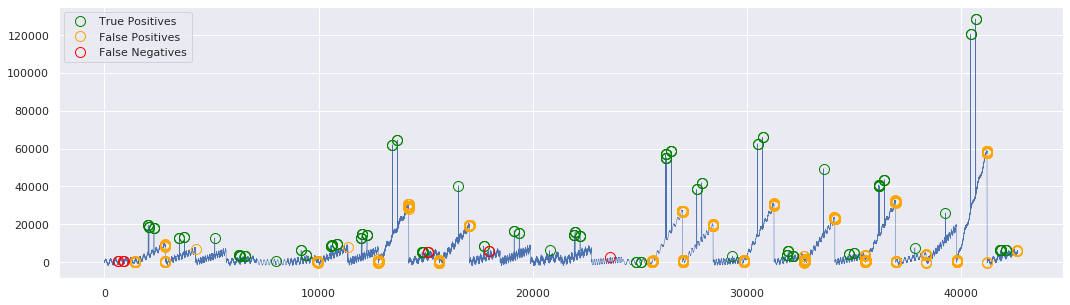

In [239]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.plot(value_col, lw=.5)
ax.plot(true_positives, 'o', mfc='none', color='green', markersize=10, label='True Positives')
ax.plot(false_positives, 'o', mfc='none', color='orange', markersize=10, label='False Positives')
ax.plot(false_negatives, 'o', mfc='none', color='red', markersize=10, label='False Negatives')
ax.legend()

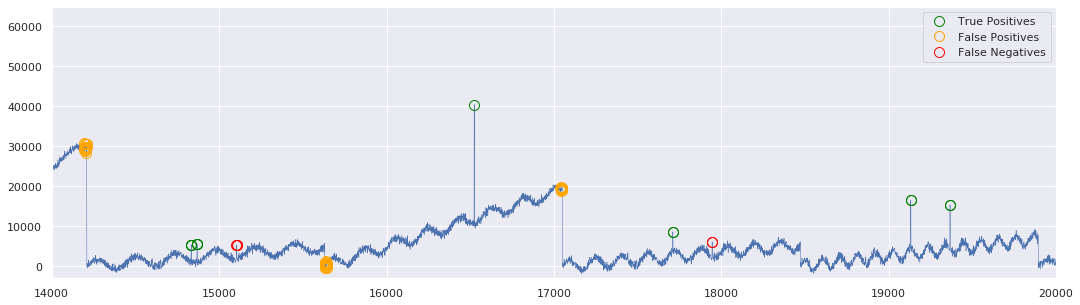

In [240]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.plot(value_col, lw=.5)
plt.xlim(14000, 20000)
plt.ylim(-3000, 65000)
ax.plot(true_positives, 'o', mfc='none', color='green', markersize=10, label='True Positives')
ax.plot(false_positives, 'o', mfc='none', color='orange', markersize=10, label='False Positives')
ax.plot(false_negatives, 'o', mfc='none', color='red', markersize=10, label='False Negatives')
ax.legend()